In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [154]:
def loc_id_cnt(num):
    df = pd.read_csv('./data/%02d.csv'%num)
    df_res = df.groupby(['time_stamp', 'loc_id']).agg({ 'phone_id':'count'})
    df_res.reset_index(inplace=True)
    return df_res
# 取3-7月的训练   3-6月训练  7月15前测试
df = pd.DataFrame()
for i in range(3, 11):
    _df = loc_id_cnt(i)
    df = df.append(_df)
#df = df[df.time_stamp<'2017-07-10 00']
    
def handle(df):
    # 时间维度
    df['datetime'] = df.time_stamp.apply(pd.to_datetime)
    del df['time_stamp']
    #df['month'] = df.datetime.apply(lambda x: x.month)
    df['day'] = df.datetime.apply(lambda x: x.day)
    df['hour'] = df.datetime.apply(lambda x: x.hour)
    df['weekday'] = df.datetime.apply(lambda x: x.weekday())
    df['weekend'] = df.datetime.apply(lambda x: int(x.weekday()>4))
    # 加入假期，节假日
    """
    def isSummer(x):
        if x > '2017-07-15 00:00:00' and x < '2017-09-03:00:00:00':
            return 1
        else:
            return 0

    def isSummerNear(x):
        if x > '2017-07-12 00:00:00' and x < '2017-07-15:00:00:00':
            return 1
        elif x > '2017-09-03 00:00:00' and x < '2017-09-06:00:00:00'::
            return 0 
    """
    def isHoliday(x):
        if x.date() == datetime.date(2017, 4, 4) or \
           x.date() == datetime.date(2017, 5, 1) or \
           x.date() == datetime.date(2017, 5, 30) or \
           x.date() == datetime.date(2017, 1, 1) or \
           x.date() >= datetime.date(2017, 10, 1) and x.date() <= datetime.date(2017, 10, 8):
            return 1
        else:
            return 0
    df['isHoliday'] = df.datetime.apply(isHoliday)
    return df
df = handle(df)

loc_df = []
for i in range(1, 34):
    _df = df[df.loc_id==i]
    _df.reset_index(inplace=True, drop=True)
    loc_df.append(_df)

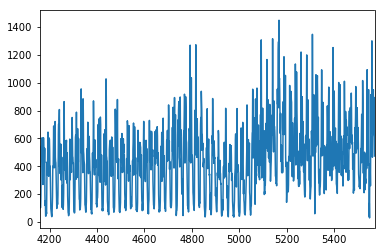

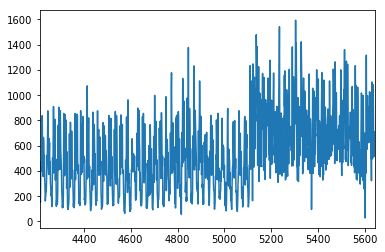

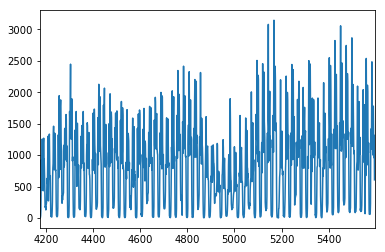

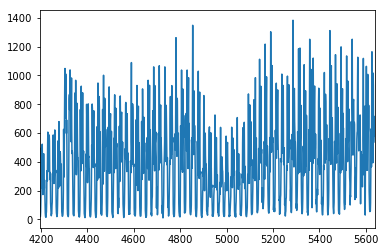

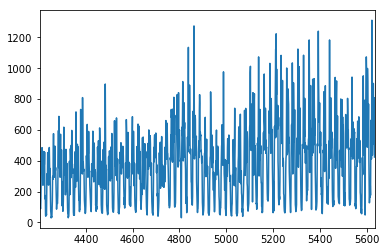

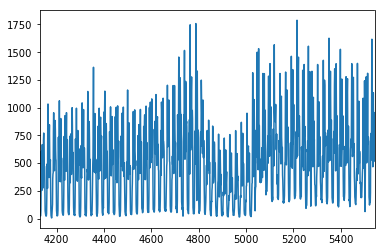

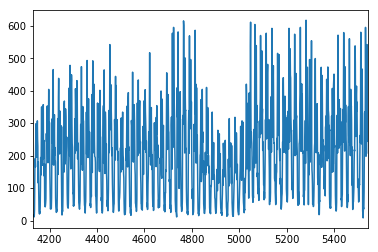

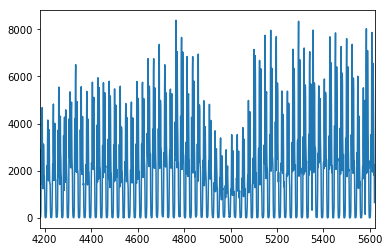

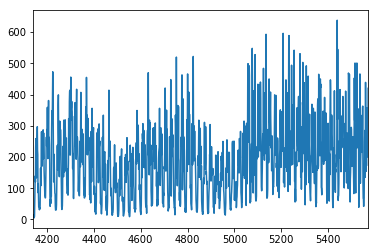

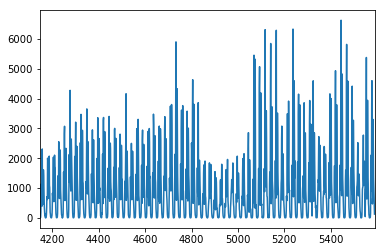

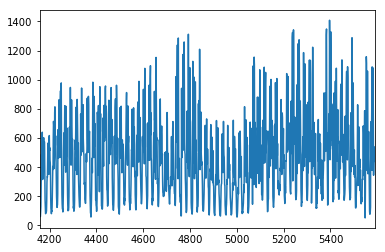

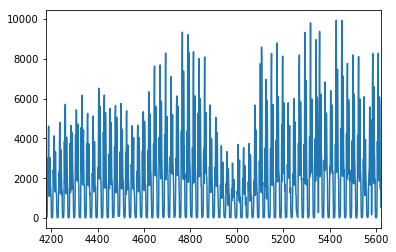

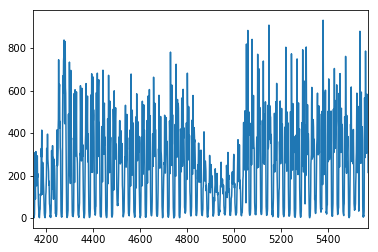

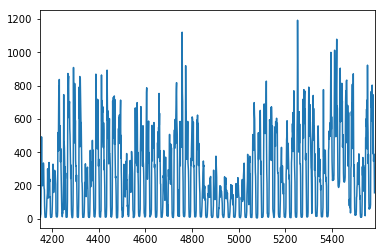

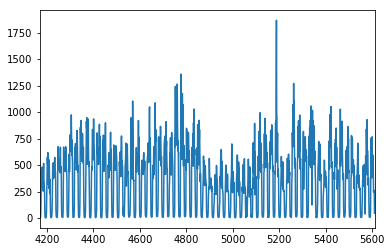

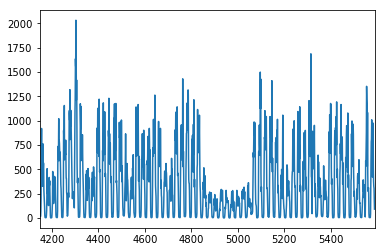

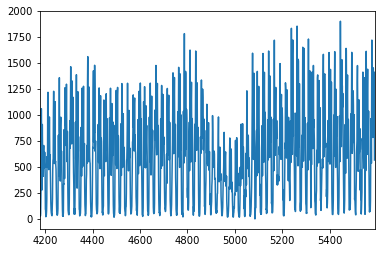

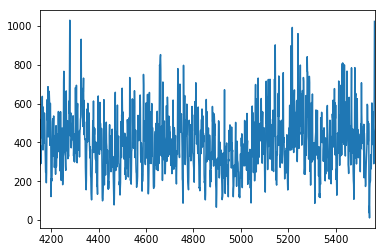

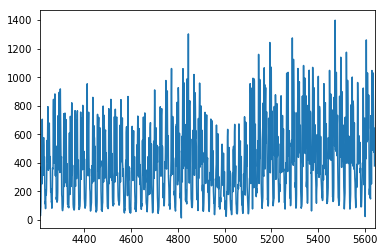

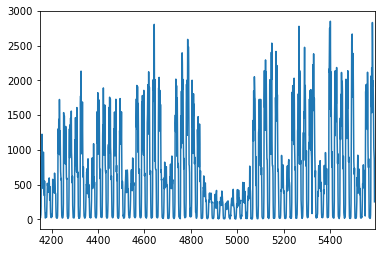

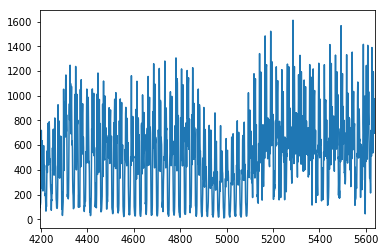

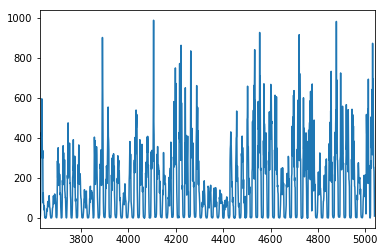

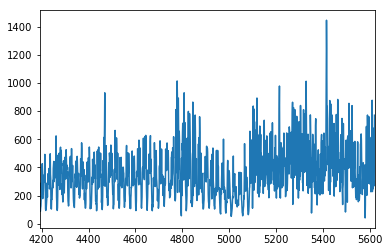

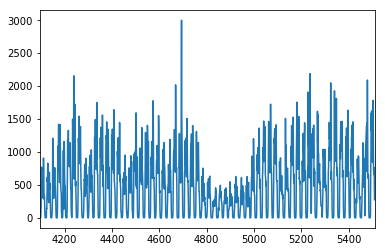

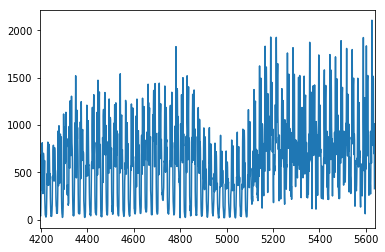

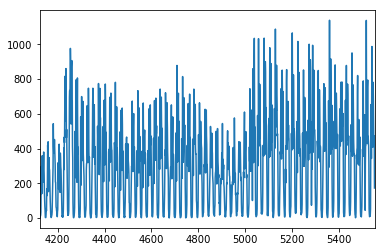

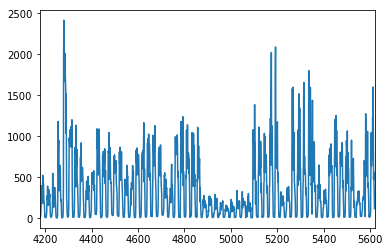

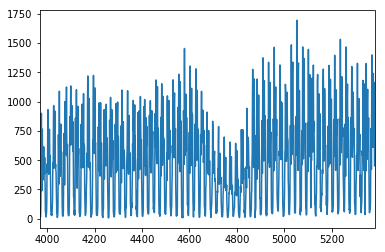

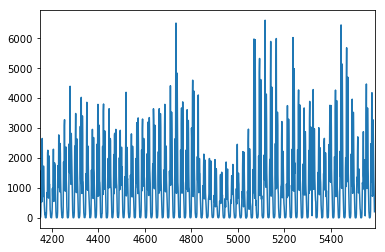

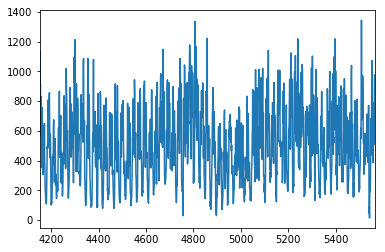

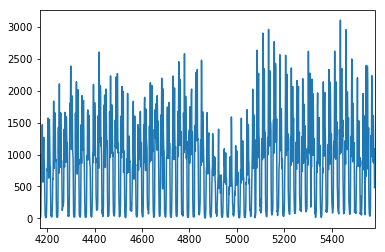

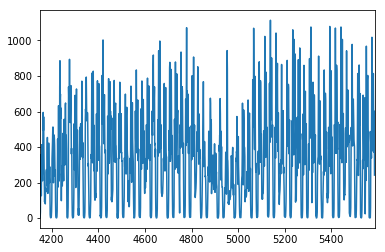

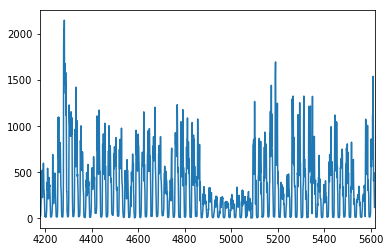

In [159]:
for i in range(len(loc_df)):
    loc_df[i][loc_df[i].datetime>'2017-09-01'].phone_id.plot()
    plt.show()

In [116]:
# load weather
def load_weather():
    w = pd.read_csv('weather.csv')
    w['datetime'] = (w.day.astype(str) + ' '+ w.time + ':00').apply(pd.to_datetime)
    del w['day']
    del w['time']
    w.head()
    return w
w = load_weather()

In [117]:
def handle_features(each, w):
    df1 = pd.merge(each, w, on='datetime', how='left')
    df1.weather.replace({u'晴天':1,
                         u'晴朗':1, 
                         u'局部多云':1,
                         u'多云': 1,
                         u'薄雾':3,
                         u'阴天':3,
                         u'周边零星小雨': 2,
                         u'细雨': 2,
                         u'小雨':2,
                         u'小雨夹雪':2,
                         u'零星细雨': 2,
                         u'零星小雨': 2,
                         u'小阵雨':2,
                         u'中雨': 4,
                         u'中到大阵雨': 4, 
                         u'周边雷暴': 4, 
                         u'零星雷雨': 4,
                         u'有时中雨': 4,
                         u'大雨': 5,
                         u'暴阵雨': 5,
                         u'中到大雷雨':5}, inplace=True)
    def handle_temp(x):
        if x < -5: return 1
        elif x < 5: return 2
        elif x < 15: return 3
        elif x < 25: return 4
        elif x< 35: return 5
        else: return 6
    df1['body_temp'] = df1.body_temp.apply(lambda x: int(x[:-1]))
    df1['temp'] = df1.temp.apply(lambda x: int(x[:-1]))
    df1['body_temp'] = df1['body_temp'].apply(handle_temp)
    df1['temp'] = df1['temp'].apply(handle_temp)
    df1['wind'] = df1.wind.apply(lambda x: int(x[:-1]) if x != '-' else 0)
    df1['shidu'] = df1.shidu.apply(lambda x: int(x[:-1]))
    df1['rain'] = df1.rain.apply(lambda x: float(x[:-2]) if x != '-' else 0)
    
    def oneHot(df, col):
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder()
        ser = df1[col]
        enc.fit([[i] for i in ser])
        arr = enc.transform([[i] for i in ser]).toarray()
        concat_df = pd.DataFrame(arr, columns=[col+'_'+str(i) for i in range(1,len(arr[1])+1)])
        df = pd.concat([df1, concat_df],axis=1)
        del df[col]
        return df
    
    df1 = oneHot(df1, 'weather')
    df1 = oneHot(df1, 'body_temp')
    df1 = oneHot(df1, 'temp')
    return df1

In [118]:
def replenish_miss_value_with_nan(each):
    carry = datetime.datetime(2017,3,1,0,0,0)
    hour_delta = datetime.timedelta(hours=1)
    time_stamp_set = set(each.datetime)

    each.set_index('datetime',inplace=True)
    while carry < datetime.datetime(2017,7,1,10,0,0):
        if carry not in time_stamp_set:
            each.loc[carry] = [np.nan for i in range(len(each.columns))]
        carry += hour_delta
    each.sort_index(inplace=True)
    each.reset_index(inplace=True)
    return each


In [119]:
def rmse(y_test, pred):
    return np.sqrt(np.mean(np.square(y_test.values - pred)))

In [120]:
def train_each_loc(locid):
    # 取一个地点的
    each = loc_df[locid]
    each.head()
    each = handle_features(each, w)
    each = replenish_miss_value_with_nan(each)
    X = each.dropna().iloc[:,3:]
    y = each.dropna().iloc[:,2]

    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    gbdt=GradientBoostingRegressor(
      loss='huber'
    , learning_rate=0.1
    , n_estimators=300
    , subsample=1
    , min_samples_split=2
    , min_samples_leaf=1
    , max_depth=3
    , init=None
    , random_state=None
    , max_features=None
    , alpha=0.9
    , verbose=1
    , max_leaf_nodes=None
    , warm_start=False
    )
    gbdt.fit(X_train,y_train)
    pred=gbdt.predict(X_test)
    print(rmse(y_test, pred))
    return gbdt

In [121]:
model_list = []
for locid in range(0, 33):
    model = train_each_loc(locid)
    model_list.append(model)

      Iter       Train Loss   Remaining Time 
         1       12651.5762            0.90s
         2       11345.1253            0.97s
         3       10267.7260            0.94s
         4        9394.8585            0.89s
         5        8634.6057            0.89s
         6        8049.6306            0.86s
         7        7517.5909            0.86s
         8        7064.6214            0.86s
         9        6678.1986            0.84s
        10        6358.7276            0.84s
        20        4844.0566            0.85s
        30        4317.0342            0.82s
        40        4011.2192            0.85s
        50        3770.4920            0.76s
        60        3508.5666            0.73s
        70        3372.5213            0.70s
        80        3258.3889            0.66s
        90        3135.1714            0.62s
       100        3035.9125            0.59s
       200        2484.4767            0.27s
       300        2190.4545            0.00s
77.223088

        80        1278.6606            0.60s
        90        1230.3488            0.57s
       100        1195.9064            0.54s
       200         978.3356            0.26s
       300         821.5971            0.00s
63.33465233274328
      Iter       Train Loss   Remaining Time 
         1      176426.7079            0.90s
         2      158612.4742            0.82s
         3      144747.1830            0.79s
         4      131386.4599            0.81s
         5      120421.0010            0.83s
         6      111943.4364            0.81s
         7      104935.7210            0.80s
         8       93806.9025            0.80s
         9       83752.8598            0.87s
        10       75795.4048            0.91s
        20       42670.2947            0.84s
        30       32413.1776            0.80s
        40       26496.0400            0.76s
        50       22891.0839            0.71s
        60       20743.3050            0.68s
        70       19772.1641         

       200        3449.4017            0.26s
       300        2965.4734            0.00s
90.26660821793287
      Iter       Train Loss   Remaining Time 
         1       11653.6134            0.75s
         2       11043.7381            0.75s
         3       10633.8487            0.79s
         4       10265.1816            0.81s
         5        9913.9570            0.83s
         6        9623.5471            0.98s
         7        9465.1087            1.05s
         8        9234.8450            1.02s
         9        9072.8656            1.00s
        10        8885.1324            0.97s
        20        7886.8545            0.88s
        30        7330.4552            0.80s
        40        6958.6195            0.86s
        50        6719.2313            0.79s
        60        6500.5338            0.72s
        70        6294.8211            0.69s
        80        6164.1511            0.64s
        90        6015.1107            0.60s
       100        5893.3864         

        60        1189.0242            0.82s
        70        1124.1894            0.77s
        80        1066.7633            0.71s
        90        1023.8954            0.67s
       100         990.3678            0.62s
       200         713.6537            0.28s
       300         586.2539            0.00s
59.58202735321274
      Iter       Train Loss   Remaining Time 
         1       17480.5144            0.90s
         2       15454.0705            0.82s
         3       13769.7496            0.84s
         4       12425.9106            0.82s
         5       11383.7417            0.83s
         6       10481.6819            1.03s
         7        9698.8241            1.01s
         8        9107.2848            0.97s
         9        8620.5946            0.95s
        10        8222.4202            0.96s
        20        6403.9662            0.94s
        30        5868.7614            0.83s
        40        5541.6641            0.78s
        50        5284.4797         

In [148]:
fl = ['day', 'hour', 'weekday', 'weekend',
       'isHoliday', 'shidu', 'wind', 'rain', 'weather_1', 'weather_2',
       'weather_3', 'weather_4', 'weather_5', 'body_temp_1', 'body_temp_2',
       'body_temp_3', 'body_temp_4', 'body_temp_5', 'temp_1', 'temp_2',
       'temp_3', 'temp_4', 'temp_5']

nov = pd.DataFrame()
time_stamp_list = []
stamp = datetime.datetime(2017,11,1,0,0,0)
time_delta = datetime.timedelta(hours=1)
while stamp < datetime.datetime(2017,12,1,0,0,0):
    time_stamp_list.append(stamp)
    stamp += time_delta
nov['datetime'] = pd.Series(time_stamp_list)
nov['time_stamp'] = pd.Series(str(i)[:-6] for i in time_stamp_list)
nov = handle(nov)
nov = handle_features(nov, w)
novfl = nov.iloc[:,1:].columns
for col in (set(fl) - set(novfl)):
    nov[col] = 0

res = pd.DataFrame()
for loc_id, model in enumerate(model_list):
    model.predict(nov.iloc[:,1:])
    _df = pd.DataFrame()
    _df['loc_id'] = [loc_id+1 for _ in range(len(nov))]
    _df['time_stamp'] = pd.Series(str(i)[:-6] for i in time_stamp_list)
    _df['num_of_people'] = model.predict(nov.iloc[:,1:])
    res = res.append(_df)

In [150]:
resNoZero = pd.DataFrame()
for locid in range(1, 34):
    tmp = res[res.loc_id==locid]
    minNum = min(tmp.num_of_people)
    tmp['num_of_people'] = tmp['num_of_people'] - minNum if minNum < 0 else tmp['num_of_people']
    resNoZero = resNoZero.append(tmp)

C:\Users\86535\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [153]:
resNoZero = resNoZero.sort_values(['time_stamp','loc_id'])
resNoZero.to_csv('gbdt_res.csv', index=False)